In [ ]:
%matplotlib inline
%pylab inline

import menpo.io as mio
from menpo.feature import no_op, sparse_hog
from menpo.landmark import labeller, ibug_face_66, ibug_face_49
from menpo.visualize import visualize_images, print_dynamic

from menpofit.fitter import noisy_shape_from_shape
from menpofit.sdm import (
    SupervisedDescentFitter, 
    Newton, GaussNewton)
from menpofit.visualize import visualize_fitting_result, plot_ced

## Load training data

In [38]:
training_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=10, normalise=False):
    i = i.crop_to_landmarks_proportion(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    i.pixels = i.pixels.astype(uint8)
    labeller(i, 'PTS', ibug_face_66)
    training_images.append(i)
    
# for i in mio.import_images('/vol/atlas/databases/helen/trainset/', 
#                            verbose=True, max_images=None, normalise=None):
#     i = i.crop_to_landmarks_proportion(0.5)
#     i = i.rescale_landmarks_to_diagonal_range(200)
#     i.pixels = i.pixels.astype(uint8)
#     labeller(i, 'PTS', ibug_face_66)
#     training_images.append(i)

Importing assets: [==========] 100% (10/10) - 00:00:00 remaining


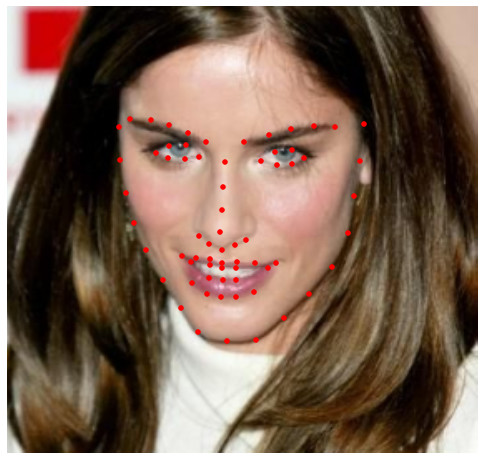

In [40]:
visualize_images(training_images)

In [72]:
i = i.rescale_landmarks_to_diagonal_range(100, 'PTS')

In [73]:
%%timeit

i.extract_patches(
    PointCloud([[0.0, 0.0]]), 
    patch_size=(17, 17),
    as_single_array=True,
    sample_offsets=PointCloud(np.require(i.indices(),dtype=np.float64)))

10 loops, best of 3: 35.5 ms per loop


In [110]:
from menpofit.math.fft_utils import fft_convolve2d_sum, fft_convolve2d, ndconvolution

f = np.random.randn(68, 3, 17, 17)

i = np.random.randn(68, 3, 17, 17)

In [115]:
%timeit fft_convolve2d_sum(i, f)

10 loops, best of 3: 79.8 ms per loop


In [105]:
fft_convolve2d_sum(i.pixels, f)

array([[[ -1.11693892e+04,  -1.01282935e+04,  -1.85792607e+04, ...,
          -1.49021777e+04,  -1.48194676e+04,  -1.17987446e+04],
        [ -5.96360469e+03,  -4.41419300e+03,  -1.28373657e+04, ...,
          -1.60899995e+04,  -1.49214604e+04,  -1.37552523e+04],
        [ -8.77598406e+03,  -8.55088709e+03,  -1.57865145e+04, ...,
          -1.60302323e+04,  -1.52348511e+04,  -1.22879603e+04],
        ..., 
        [ -1.81301591e+04,  -1.09629821e+04,  -2.45314486e+04, ...,
          -3.61218040e+04,  -4.41997990e+04,  -3.63636651e+04],
        [ -1.64519304e+04,  -1.15097897e+04,  -2.22796990e+04, ...,
          -2.86588588e+04,  -3.58385702e+04,  -2.87970705e+04],
        [ -2.01900338e+04,  -1.66600087e+04,  -2.00892929e+04, ...,
          -2.28536419e+04,  -2.98442215e+04,  -2.34217772e+04]],

       [[ -1.27918409e+04,  -1.38356511e+04,  -1.67684309e+04, ...,
          -1.59145567e+04,  -1.14373407e+04,  -1.11720787e+04],
        [ -1.25669177e+04,  -1.26851224e+04,  -1.53596898e+0

In [106]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [112]:
# TODO: document me!
def pad(pixels, ext_shape, boundary='constant'):
    h, w = pixels.shape[-2:]

    h_margin = (ext_shape[0] - h) // 2
    w_margin = (ext_shape[1] - w) // 2

    h_margin2 = h_margin
    if h + 2 * h_margin < ext_shape[0]:
        h_margin += 1

    w_margin2 = w_margin
    if w + 2 * w_margin < ext_shape[1]:
        w_margin += 1

    pad_width = []
    for _ in pixels.shape[:-2]:
        pad_width.append((0, 0))
    pad_width += [(h_margin, h_margin2), (w_margin, w_margin2)]
    pad_width = tuple(pad_width)

    return np.lib.pad(pixels, pad_width, mode=boundary)


# TODO: document me!
def crop(pixels, shape):
    h, w = pixels.shape[-2:]

    h_margin = (h - shape[0]) // 2
    w_margin = (w - shape[1]) // 2

    h_corrector = 1 if np.remainder(h - shape[0], 2) != 0 else 0
    w_corrector = 1 if np.remainder(w - shape[1], 2) != 0 else 0

    return pixels[...,
                  h_margin + h_corrector:-h_margin,
                  w_margin + w_corrector:-w_margin]


def fft_convolve2d(x, f, mode='same', boundary='constant'):
    r"""
    Performs fast 2d convolution in the frequency domain convolving each image
    channel with its corresponding filter channel.

    Parameters
    ----------
    x : ``(channels, height, width)`` `ndarray`
        Image.
    f : ``(channels, height, width)`` `ndarray`
        Filter.
    mode : str {`full`, `same`, `valid`}, optional
        Determines the shape of the resulting convolution.
    boundary: str {`constant`, `symmetric`}, optional
        Determines how the image is padded.
    Returns
    -------
    c: ``(channels, height, width)`` `ndarray`
        Result of convolving each image channel with its corresponding
        filter channel.
    """
    # extended shape
    x_shape = np.asarray(x.shape[-2:])
    f_shape = np.asarray(f.shape[-2:])
    ext_shape = x_shape + f_shape - 1

    # extend image and filter
    ext_x = pad(x, ext_shape, boundary=boundary)
    ext_f = pad(f, ext_shape)

    # compute ffts of extended image and extended filter
    fft_ext_x = fft2(ext_x)
    fft_ext_f = fft2(ext_f)

    # compute extended convolution in Fourier domain
    fft_ext_c = fft_ext_f * fft_ext_x

    # compute ifft of extended convolution
    ext_c = np.real(ifftshift(ifft2(fft_ext_c), axes=(-2, -1)))

    if mode is 'full':
        return ext_c
    elif mode is 'same':
        return crop(ext_c, x_shape)
    elif mode is 'valid':
        return crop(ext_c, x_shape - f_shape + 1)
    else:
        raise ValueError(
            "mode={}, is not supported. The only supported "
            "modes are: 'full', 'same' and 'valid'.".format(mode))


# TODO: document me!
def fft_convolve2d_sum(x, f, mode='same', boundary='constant', axis=0,
                       keepdims=False):
    r"""
    Performs fast 2d convolution in the frequency domain convolving each image
    channel with its corresponding filter channel and summing across the
    channel axis.

    Parameters
    ----------
    x : ``(channels, height, width)`` `ndarray`
        Image.
    f : ``(channels, height, width)`` `ndarray`
        Filter.
    mode : str {`full`, `same`, `valid`}, optional
        Determines the shape of the resulting convolution.
    boundary: str {`constant`, `symmetric`}, optional
        Determines how the image is padded.
    axis : `int`, optional
        The axis across to which the summation is performed.
    keepdims: `boolean`, optional
        If `True` the number of dimensions of the result is the same as the
        number of dimensions of the filter. If `False` the channel dimension
        is lost in the result.
    Returns
    -------
    c: ``(1, height, width)`` `ndarray`
        Result of convolving each image channel with its corresponding
        filter channel and summing across the channel axis.
    """
    return np.sum(fft_convolve2d(x, f, mode=mode, boundary=boundary),
                  axis=axis, keepdims=keepdims)

In [113]:
%lprun -f fft_convolve2d fft_convolve2d_sum(i, f)

## Load test data

In [109]:
test_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/testset/', 
                           verbose=True, max_images=None, normalise=None):    
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    test_images.append(i)

Importing assets: [==========] 100% (224/224) - 00:00:00 remaining


In [ ]:
visualize_images(test_images)

## Train Supervised Fitter

In [ ]:
sd_algorithm_cls = Newton
features = [sparse_hog]
patch_shape = (17, 17)
diagonal = 200
scales = (1, .5)
iterations = 4
n_perturbations = 10

group = 'ibug_face_66'
verbose = True
l = 0

In [ ]:
sd_fitter_batch = SupervisedDescentFitter(
    sd_algorithm_cls=sd_algorithm_cls,
    features=features,
    patch_shape=patch_shape,
    diagonal=diagonal, 
    scales=scales,
    iterations=iterations,
    n_perturbations=n_perturbations)
    
sd_fitter_batch.train(
    training_images,
    group=group,
    verbose=verbose,
    l=l)

In [ ]:
sd_fitter_incremental = SupervisedDescentFitter(
    sd_algorithm_cls=sd_algorithm_cls,
    features=features,
    patch_shape=patch_shape,
    diagonal=diagonal, 
    scales=scales,
    iterations=iterations,
    n_perturbations=n_perturbations)
    
sd_fitter_incremental.train_incrementally(    
    training_images,
    batch_size=300,
    group=group,
    verbose=verbose,
    l=l)

#### Fitting loop

In [ ]:
fitters = [sd_fitter_batch, sd_fitter_incremental]

fitters_results = []

for j, i in enumerate(test_images):
    
    #np.random.seed(j)
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitters[0].perturb_from_shape(gt_s, noise_std=0.05)

    for fitter in fitters:
        
        fr = fitter.fit(i, s, gt_shape=gt_s) 
        fr.downscale = 0.5
        fitters_results.append(fr)
    
        print 'Image: ', j
        print fr

## Results

In [ ]:
initial_errors = [fr.initial_error() for fr in fitters_results[::2]]

final_errors_1 = [fr.final_error() for fr in fitters_results[::2]]
final_errors_2 = [fr.final_error() for fr in fitters_results[1::2]]

In [ ]:
print 'ini:', np.mean(initial_errors), 'std_1:', np.std(initial_errors), 'median:', np.median(initial_errors) 
print 'mean_1:', np.mean(final_errors_1), 'std_1:', np.std(final_errors_1), 'median:', np.median(final_errors_1) 
print 'mean_2:', np.mean(final_errors_2), 'std_2:', np.std(final_errors_2), 'median:', np.median(final_errors_2) 

In [ ]:
errors = [initial_errors, final_errors_1, final_errors_2]

In [ ]:
plot_ced(errors, legend_entries=['ini', '1', '2'])

In [ ]:
visualize_fitting_result(fitters_results[::2])

In [ ]:
visualize_fitting_result(fitters_results[1::2])

## Timing

In [ ]:
%timeit -n 25 fr = sd_fitter_batch.fit(i, s, gt_shape=gt_s) 
%timeit -n 25 fr = sd_fitter_incremental.fit(i, s, gt_shape=gt_s) 

In [ ]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
%lprun -f Newton.run fitter.fit(i, s, gt_shape=gt_s)